In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorboard

import os
import cv2
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import skimage
from skimage import color, metrics, filters
from skimage.color import rgb2gray
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
import pytz
import math

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.core.util import event_pb2
from keras.preprocessing.image import ImageDataGenerator


import tensorboard
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# CHANGE THESE!!!
pwd = '/content/drive/MyDrive/COMP3362_Proj/'

In [ ]:
# Parameters (Can change)
categoryTestSize = 3        # How many test data for each label
validation_percent = 0.2

# Constant Variables (Don't change)
data_dir = pwd + 'Datasets/FIDS30'
tz = pytz.timezone('Asia/Hong_Kong')
DIMENSION = (256, 256)
RESAMPLE = 3

# Classes

## Data

In [ ]:
class Data():
  def __init__(self, labelsToInclude=[], testSize=3):
    # Config data
    self.labelsToInclude = labelsToInclude # Empty labels means all data

    # Labels
    self.labels = []

    # Training Data
    self.trainingSize = 0
    self.trainImages = []
    self.x_train = None
    self.y_train = None

    # Test Data
    self.testSize = testSize
    self.testImages = dict()
    self.rgb_org_test = dict()
    self.gray_org_test = dict()
    self.lab_org_test = dict()
    self.l_org_test = dict()



  def loadImages(self):
    data_paths = []
    self.trainImages = []
    self.labels = []
    self.testImages = dict()

    ###################################
    ######### Load Data Paths #########
    ###################################
    print('Loading image paths...')
    print('')

    # Get data paths
    for dirname, _, filenames in os.walk(data_dir):
      for filename in filenames:
        file_path = os.path.join(dirname, filename)

        label = file_path.split('/')[-2]

        if (len(self.labelsToInclude) == 0 or label in self.labelsToInclude):
          data_paths.append((file_path, label))

    data_size = len(data_paths)

    print('Data paths loaded!')
    print('     Number of data:', data_size)
    print('')

    ###################################
    ########### Load Images ###########
    ###################################
    print('Loading images from paths...')
    print('')

    # Load and resize image
    for data_path, label in data_paths:
      image = np.asarray(Image.open(data_path))
      
      # Expand if only 2 in dimensions
      if (image.ndim==2):
        image = np.tile(image[:,:,None],3)
      
      # remove CMYK or RGBA image representation
      if (np.asarray(image).shape[2] != 3):
        continue
      
      # Resize Image
      image = Image.fromarray(image).resize(DIMENSION, resample=RESAMPLE)

      if (label not in self.testImages):
        self.testImages[label] = [np.asarray(image)]
      elif (len(self.testImages[label]) < self.testSize):
        self.testImages[label].append(np.asarray(image))
      else:
        self.trainImages.append(np.asarray(image))

      self.labels.append(label)

    # Convert to np array
    self.trainImages = np.asarray(self.trainImages)
    self.labels = np.asarray(self.labels)
    for label in self.testImages:
      self.testImages[label] = np.asarray(self.testImages[label])
    
    self.trainingSize = self.trainImages.shape[0]

    print('Images Loaded!')
    print('     Shape  of training data:', self.trainImages.shape)
    print('     Number of test data:')
    for label in self.testImages:
      print(f'       {label:10}: {len(self.testImages[label])}')

  
  def dataAugmentation(self, dataset_multiply=10, rotation_range=30, zoom_range=0.3, horizontal_flip=True):
    # Augment data
    train_augmentation = ImageDataGenerator(rotation_range=rotation_range,
                                            zoom_range=zoom_range,
                                            horizontal_flip=horizontal_flip,
                                            rescale=1./255)
    
    augmented_images = train_augmentation.flow(self.trainImages, batch_size=1)

    # Retrieve Augmented data
    trainImagesTemp = []

    i = 0
    for augmented_image in augmented_images:
      image = augmented_image[0]
      trainImagesTemp.append(image)

      i += 1
      if (i >= self.trainingSize * dataset_multiply):
        break

    self.trainImages = np.asarray(trainImagesTemp)
    self.trainingSize = len(self.trainImages)
    print('Augmented data shape:', self.trainImages.shape)
  
  def dataProcessing(self, image):
    # Change to LAB Space
    lab_image = color.rgb2lab(image)

    # Get L Space
    l_image = lab_image[:,:,0]

    # Get AB Space
    ab_image = lab_image[:,:,1:] / 100.

    return l_image, ab_image
  
  def processTrainingData(self):
    l_train = []   # L  of LAB image
    ab_train = []  # AB of LAB image

    for image in self.trainImages:
      l_image, ab_image = self.dataProcessing(image)

      l_train.append(l_image)
      ab_train.append(ab_image)

    # # Convert to np array with correct shape
    l_train = np.asarray(l_train)
    self.x_train = l_train.reshape(l_train.shape[0], l_train.shape[1], l_train.shape[2], 1)
    self.y_train = np.asarray(ab_train)

    print("Training Shape:")
    print("  Training Input  Images in L Space   :", self.x_train.shape)
    print("  Training Output Images in AB Space  :", self.y_train.shape)
    print('')
  
  def processTestData(self):
    self.rgb_org_test = dict()
    self.gray_org_test = dict()
    self.lab_org_test = dict()
    self.l_org_test = dict()

    test_augmentation = ImageDataGenerator(rescale=1./255)

    for label in self.testImages:
      rgb_list = []
      gray_list = []
      lab_list = []
      l_list = []

      test_images_label = test_augmentation.flow(self.testImages[label], batch_size=128, shuffle=False)

      for numBatch in range(len(test_images_label)):
        for image in test_images_label[numBatch]:
          rgb_image = np.asarray(image)
          gray_image = color.rgb2gray(rgb_image)
          lab_image = color.rgb2lab(rgb_image)
          l_image = lab_image[:,:,0]

          rgb_list.append(rgb_image)
          gray_list.append(gray_image)
          lab_list.append(lab_image)
          l_list.append(l_image)
      
      self.rgb_org_test[label] = np.asarray(rgb_list)
      self.gray_org_test[label] = np.asarray(gray_list)
      self.lab_org_test[label] = np.asarray(lab_list)
      
      l_list = np.asarray(l_list)
      l_list = l_list.reshape(l_list.shape[0], l_list.shape[1], l_list.shape[2], 1)
      self.l_org_test[label] = l_list
      
    labelToPrint = self.labels[0] if len(self.labels) > 0 else 'bananas'
    print(f"Testing Shape (category: {labelToPrint}):")
    print("  Resized Test Image in RGB  Space   :", self.rgb_org_test[labelToPrint].shape)
    print("  Resized Test Image in gray Space   :", self.gray_org_test[labelToPrint].shape)
    print("  Resized Test Image in LAB  Space   :", self.lab_org_test[labelToPrint].shape)
    print("  Resized Test Image in L    Space   :", self.l_org_test[labelToPrint].shape)
    print('')

  
  def checkDistribution(self, title):
    image_df = pd.DataFrame(data=self.labels, columns=['Fruit'])

    graph = image_df['Fruit'].value_counts()[:]
    graph.plot(kind='bar',figsize=(10,8))
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(rotation=0, fontsize=12)
    plt.xlabel('Fruits', fontsize=16)
    plt.ylabel('Distribution', fontsize=16)
    plt.title('title', fontsize=20)
  
  def showImage(self, imageArray, axis='on', grayscale=False):
    if (grayscale):
      plt.imshow(imageArray, cmap='gray', interpolation='nearest')
    else:
      plt.imshow(imageArray, interpolation='nearest')

    plt.axis(axis)
    plt.show()

## Model

In [ ]:
class ColorizationModel():

  def __init__(self, modelName, modelChoice='modelC', learningRate=0.002, decay=0.9, lossChoice='mse'):
    modelName = datetime.now(tz=tz).strftime("%m-%d %H:%M:%S ") + modelName
    self.modelLogDir = pwd + 'ModelLog (Kyle)/' + modelName
    self.trainedModelDir = pwd + 'TrainedModel (Kyle)/' + modelName
    self.model = None
    self.history = None
    self.tesnorboard_callback = None

    if (modelChoice == 'modelA'):
      self.model = self.ModelA()
    elif (modelChoice == 'modelB'):
      self.model = self.ModelB()
    elif (modelChoice == 'modelC'):
      self.model = self.ModelC()
    elif (modelChoice == 'modelD'):
      self.model = self.ModelD()
    else:
      print('No Such Model (Not Yet Implemented In Class?)')
      return
    if (lossChoice == 'mse'):
      loss = 'mse'
      optimizer= tf.keras.optimizers.Adam(learning_rate=learningRate, decay=decay, clipnorm=1.0)
      self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    elif (lossChoice == 'NegSSIM'):
      optimizer= tf.keras.optimizers.Adam(learning_rate=learningRate, decay=decay, clipnorm=1.0)
      self.model.compile(optimizer=optimizer, loss=CustomAccuracy_NegSSIM, metrics=[CustomAccuracy_NegSSIM, 'accuracy'])

    elif (lossChoice == 'OneNegSSIM'):
      optimizer= tf.keras.optimizers.Adam(learning_rate=learningRate, decay=decay, clipnorm=1.0)
      self.model.compile(optimizer=optimizer, loss=CustomAccuracy_OneNegSSIM, metrics=[CustomAccuracy_OneNegSSIM, 'accuracy'])  
    else:
      print('No Such Loss (Not Yet Implemented In Class?)')

    self.model.summary()
    self.tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=self.modelLogDir)

    print('')
    print('Model Information:')
    print(f'Model of choice: {modelChoice}')
    print(f'Learning Rate: {learningRate}')
    print(f'Decay: {decay}')
    print(f'Loss Choice: {lossChoice}')
    print('')
    print(f'Model Log Directory     : {self.modelLogDir}')
    print(f'Trained Model Directory : {self.trainedModelDir}')
  
  def train(self, x_train, y_train, epochs, batch_size=128):
    print('Range:')
    print(f'x_train: [{x_train.min()}, {x_train.max()}]')
    print(f'y_train: [{y_train.min()}, {y_train.max()}]')
    self.history = self.model.fit(x=x_train, y=y_train, validation_split=validation_percent, epochs=epochs, batch_size=batch_size, callbacks=[self.tensorboard_callback], shuffle=True)

    self.model.save(self.trainedModelDir)

    print('\nWAIT! Saving Model...')

    print('\nTraining Finished')
    print('   Model Log saved in      :', self.modelLogDir)
    print('   Trained Model saved in  :', self.trainedModelDir)

  def ModelA(self):
    modelA = Sequential([
      # Encoder
      Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)),
      Conv2D(128, (3, 3), activation='relu', padding='same'),
      Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
      Conv2D(256, (3,3), activation='relu', padding='same'),
      Conv2D(256, (3,3), activation='relu', padding='same', strides=2),
      Conv2D(512, (3,3), activation='relu', padding='same'),

      # Decoder
      Conv2D(512, (3,3), activation='relu', padding='same'),
      Conv2D(256, (3,3), activation='relu', padding='same'),
      Conv2D(128, (3,3), activation='relu', padding='same'),
      UpSampling2D((2, 2)),
      Conv2D(64, (3,3), activation='relu', padding='same'),
      UpSampling2D((2, 2)),
      Conv2D(32, (3,3), activation='relu', padding='same'),
      Conv2D(16, (3,3), activation='relu', padding='same'),
      Conv2D(2, (3, 3), activation='relu', padding='same'),
      UpSampling2D((2, 2))
    ])
    return modelA
  
  def ModelB(self):
    modelB = Sequential([
      # Encoder
      Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)),
      Conv2D(128, (3, 3), activation='relu', padding='same'),
      Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
      Conv2D(256, (3,3), activation='relu', padding='same'),
      Conv2D(256, (3,3), activation='relu', padding='same', strides=2),
      Conv2D(512, (3,3), activation='relu', padding='same'),

      # Dilation layer
      Conv2D(512, (3,3), activation='relu', padding='same', dilation_rate=2),
      Conv2D(512, (3,3), activation='relu', padding='same', dilation_rate=2),
      Conv2D(512, (3,3), activation='relu', padding='same', dilation_rate=2),

      # Decoder
      Conv2D(256, (3,3), activation='relu', padding='same'),
      Conv2D(128, (3,3), activation='relu', padding='same'),
      UpSampling2D((2, 2)),
      Conv2D(64, (3,3), activation='relu', padding='same'),
      UpSampling2D((2, 2)),
      Conv2D(32, (3,3), activation='relu', padding='same'),
      Conv2D(16, (3,3), activation='relu', padding='same'),
      Conv2D(2, (3, 3), activation='relu', padding='same'),
      UpSampling2D((2, 2))
    ])
    return modelB
  
  def modelC(self):
    # Model C
    modelC = Sequential([
      # Encoder
      Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)),
      Conv2D(128, (3, 3), activation='relu', padding='same'),
      Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
      Conv2D(256, (3,3), activation='relu', padding='same'),
      Conv2D(256, (3,3), activation='relu', padding='same', strides=2),
      Conv2D(512, (3,3), activation='relu', padding='same'),

      # Dilation layer
      Conv2D(512, (3,3), activation='relu', padding='same', dilation_rate=2),
      Conv2D(512, (3,3), activation='relu', padding='same', dilation_rate=2),
      Conv2D(512, (3,3), activation='relu', padding='same', dilation_rate=2),
      Conv2D(512, (3,3), activation='relu', padding='same', dilation_rate=2),

      # Decoder
      Conv2D(512, (3,3), activation='relu', padding='same'),
      Conv2D(256, (3,3), activation='relu', padding='same'),
      UpSampling2D((2, 2)),
      Conv2D(128, (3,3), activation='relu', padding='same'),
      Conv2D(64, (3,3), activation='relu', padding='same'),
      UpSampling2D((2, 2)),
      Conv2D(32, (3,3), activation='relu', padding='same'),
      Conv2D(16, (3,3), activation='relu', padding='same'),
      Conv2D(2, (3, 3), activation='relu', padding='same'),
      UpSampling2D((2, 2))
    ])
    return modelC
  
  def ModelD(self):
    modelD = Sequential([
      # Encoder
      Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)),
      Conv2D(128, (3, 3), activation='relu', padding='same'),
      Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
      Conv2D(256, (3,3), activation='relu', padding='same'),
      Conv2D(256, (3,3), activation='relu', padding='same', strides=2),
      Conv2D(512, (3,3), activation='relu', padding='same'),

      # Decoder
      Conv2D(512, (3,3), activation='relu', padding='same'),
      Conv2D(256, (3,3), activation='relu', padding='same'),
      Conv2D(128, (3,3), activation='relu', padding='same'),
      UpSampling2D((2, 2)),
      Conv2D(64, (3,3), activation='relu', padding='same'),
      UpSampling2D((2, 2)),
      Conv2D(32, (3,3), activation='relu', padding='same'),
      Conv2D(16, (3,3), activation='relu', padding='same'),
      Conv2D(2, (3, 3), activation='tanh', padding='same'),
      UpSampling2D((2, 2))
    ])
    return modelD

## Evaluation

In [ ]:
class Evaluation():
  def __init__(self, needUnnormalized=False):
    self.needUnnormalized = needUnnormalized

  def showAccuracyAndLossLoad(self, modelName, trainName, validName, accuracyTitle, lossTitle, start=10, titleFontSize=18):
    event_file = pwd + 'ModelLog (Kyle)/' + modelName
    event_training = event_file + '/train/' + trainName
    event_validation = event_file + '/validation/' + validName

    training_accuracy = []
    training_loss = []
    validation_accuracy = []
    validation_loss = []
    epoch = []

    serialized_examples = tf.data.TFRecordDataset(event_training)
    for serialized_example in serialized_examples:
        event = event_pb2.Event.FromString(serialized_example.numpy())
        for value in event.summary.value:
            t = tf.make_ndarray(value.tensor)
            # print(value.tag, event.step, t, type(t)) 
            if (value.tag == 'epoch_accuracy'):
              training_accuracy.append(np.float32(t))
              epoch.append(event.step)
            elif (value.tag == 'epoch_loss'):
              training_loss.append(np.float32(t))



    serialized_examples = tf.data.TFRecordDataset(event_validation)
    for serialized_example in serialized_examples:
        event = event_pb2.Event.FromString(serialized_example.numpy())
        for value in event.summary.value:
            t = tf.make_ndarray(value.tensor)
            # print(value.tag, event.step, t, type(t))
            if (value.tag == 'epoch_accuracy'):
              validation_accuracy.append(np.float32(t))
            elif (value.tag == 'epoch_loss'):
              validation_loss.append(np.float32(t))


    plt.plot(epoch[start:], training_accuracy[start:], label = "Training")
    plt.plot(epoch[start:], validation_accuracy[start:], label = "Validation")
    plt.title(accuracyTitle, fontsize=titleFontSize)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel('accuracy', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.legend()
    plt.show()

    plt.plot(epoch[start:], training_loss[start:], label = "Training")
    plt.plot(epoch[start:], validation_loss[start:], label = "Validation")
    plt.title(lossTitle, fontsize=titleFontSize)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.legend()
    plt.show()

  def showAccuracyAndLoss(self, history, accuracyAllName, lossAllName, accuracyPartName, lossPartName, start=10):
    # Full Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(accuracyAllName)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Full Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(lossAllName)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # From Starting Point Accuracy
    plt.plot(history.history['accuracy'][start:])
    plt.plot(history.history['val_accuracy'][start:])
    plt.title(accuracyPartName)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # From Starting Point Loss
    plt.plot(history.history['loss'][start:])
    plt.plot(history.history['val_loss'][start:])
    plt.title(lossPartName)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

  def showOneImageInfo(self, i, label, data, model):
    test_image = data.l_org_test[label][i:i+1]
    model_output = model.predict(test_image, verbose=0)
    if (self.needUnnormalized):
      model_output *= 100

    # Predicted Image
    l_test_image = test_image[0]
    predicted_ab = model_output[0]
    predicted_lab = np.concatenate((l_test_image, predicted_ab),axis=2)
    predicted_rgb = color.lab2rgb(predicted_lab)

    # Original Image
    original_lab = data.lab_org_test[label][i]
    original_gray = data.gray_org_test[label][i]
    original_rgb = data.rgb_org_test[label][i]

    print('')
    print(f'Predicted value range:')
    print(f'  L  : [{l_test_image.min()}, {l_test_image.max()}]')
    print(f'  AB : [{predicted_ab.min()}, {predicted_ab.max()}]')
    print(f'  LAB: [{predicted_lab.min()}, {predicted_lab.max()}]')
    print(f'  RGB: [{predicted_rgb.min()}, {predicted_rgb.max()}]')
    print(f'Original value range:')
    print(f'  LAB: [{original_lab.min()}, {original_lab.max()}]')
    print(f'  RGB: [{original_rgb.min()}, {original_rgb.max()}]')
    print(f'  Gry: [{original_gray.min()}, {original_gray.max()}]')
    print('')

    
    self.showImage(original_gray, axis='off', grayscale=True, title='Original Gray')
    self.showImage(predicted_rgb, axis='off', title='Predicted RGB')
    self.showImage(original_rgb, axis='off', title='Original RGB')
    self.showImage(original_lab, axis='off', title='Original LAB')
    self.showImage(predicted_lab, axis='off', title='Predicted LAB')
    print('')
    print('Originial LAB Image 0 to 1')
    self.showImage(original_lab / 100.0, axis='off', title='Original LAB (Rescaled)')
    print('')
    print('Predicted LAB Image 0 to 1')
    self.showImage(predicted_lab / 100.0, axis='off', title='Predicted LAB (Rescaled)')
    print('')
    print('Original LAB 3D Graph')
    self.plotColor3DGraph(original_lab)
    print('')
    print('Predicted LAB 3D Graph')
    self.plotColor3DGraph(predicted_lab)
    print('')
    print('Original LAB 2D Graph')
    self.plotColor2DGraph(original_lab)
    print('')
    print('Predicted LAB 2D Graph')
    self.plotColor2DGraph(predicted_lab)

    self.showLABSpace(original_lab, predicted_lab)

    # plt.show()
  
  def plotColor2DGraph(self, lab_image):
    limit = 100
    y,x,z = lab_image.shape
    rgb_color = color.lab2rgb(lab_image)
    lab_image_flat = np.float32(np.reshape(lab_image, [y*x,z]))
    rgb_color_flat = np.float32(np.reshape(rgb_color, [y*x,z]))

    print(lab_image.shape)
    print(lab_image_flat.shape)
    print(f'Range: [{lab_image_flat.min()}, {lab_image_flat.max()}]')

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim([-limit, limit])
    ax.set_ylim([-limit, limit])

    ax.scatter(x=lab_image_flat[:,2], y=lab_image_flat[:,1], c=rgb_color_flat)

    quiver1 = ax.quiver([0],[0],[limit],[0], color='y')
    quiver2 = ax.quiver([0],[0],[-limit],[0], color='b')
    quiver3 = ax.quiver([0],[0],[0],[limit], color='r')
    quiver4 = ax.quiver([0],[0],[0],[-limit], color='g')

    # Set labels
    ax.set_xlabel('B space')
    ax.set_ylabel('A space')

    plt.show()
  
  def plotColor3DGraph(self, lab_image):
    limit = 100
    y,x,z = lab_image.shape
    rgb_color = color.lab2rgb(lab_image)
    lab_image_flat = np.float32(np.reshape(lab_image, [y*x,z]))
    rgb_color_flat = np.float32(np.reshape(rgb_color, [y*x,z]))

    print(lab_image.shape)
    print(lab_image_flat.shape)
    print(f'Range: [{lab_image_flat.min()}, {lab_image_flat.max()}]')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlim3d([-limit, limit])
    ax.set_ylim3d([-limit, limit])
    ax.set_zlim3d([0, limit])

    ax.scatter(xs=lab_image_flat[:,2], ys=lab_image_flat[:,1], zs=lab_image_flat[:,0], c=rgb_color_flat)

    quiver1 = ax.quiver([0],[0],[0],[limit],[0],[0], colors='y')
    quiver2 = ax.quiver([0],[0],[0],[-limit],[0],[0], colors='b')
    quiver3 = ax.quiver([0],[0],[0],[0],[limit],[0], colors='r')
    quiver4 = ax.quiver([0],[0],[0],[0],[-limit],[0], colors='g')
    quiver5 = ax.quiver([0],[0],[0],[0],[0],[limit], color='black')

    # Data for plotting plane x|y|z=0 within the domain
    tmp = np.linspace(0, limit, 8)
    x,y = np.meshgrid(tmp,tmp)
    z = 0*x

    ax.plot_surface(z,x,y, alpha=0.15, color='red')    # plot the plane x=0
    ax.plot_surface(z,-x,y, alpha=0.15, color='green')    # plot the plane x=0
    ax.plot_surface(x,z,y, alpha=0.15, color='yellow')  # plot the plane y=0
    ax.plot_surface(-x,z,y, alpha=0.15, color='blue')  # plot the plane y=0

    

    # Set labels at the 3d box/frame
    ax.set_xlabel('B space')
    ax.set_ylabel('A space')
    ax.set_zlabel('L space')

    plt.show()

  
  def showLABSpace(self, original_lab, predicted_lab):
    top = cm.get_cmap('Greens_r', 128)
    bottom = cm.get_cmap('Reds', 128)
    newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                          bottom(np.linspace(0, 1, 128))))
    redGreenCmap = ListedColormap(newcolors, name='RedGreen')

    # top = cm.get_cmap('Blues_r', 128)
    # bottom = cm.get_cmap('Yellows', 128)
    # newcolors = np.vstack((top(np.linspace(0, 1, 128)),
    #                       bottom(np.linspace(0, 1, 128))))
    # yellowBlueCmap = ListedColormap(newcolors, name='YellowBlue')

    count = 1
    fig = plt.figure(figsize=(10,3*2))
        
    # Original
    ax = fig.add_subplot(2,3,count)
    lab_rgb_gray = original_lab[:,:,0]
    ax.imshow(lab_rgb_gray, cmap='Greys')
    ax.axis("off")
    ax.set_title("Original L: Lightness")
    count += 1
    
    ax = fig.add_subplot(2,3,count)
    lab_rgb_gray = original_lab[:,:,1]
    ax.imshow(lab_rgb_gray, cmap=redGreenCmap)
    ax.axis("off")
    ax.set_title("Original A: green to red")
    count += 1

    ax = fig.add_subplot(2,3,count)
    lab_rgb_gray = original_lab[:,:,2]
    ax.imshow(lab_rgb_gray, cmap='YlGnBu_r')
    ax.axis("off")
    ax.set_title("Original B: blue to yellow")
    count += 1

    # Predicted
    ax = fig.add_subplot(2,3,count)
    lab_rgb_gray = predicted_lab[:,:,0]
    ax.imshow(lab_rgb_gray, cmap='Greys')
    ax.axis("off")
    ax.set_title("Predicted L: lightness")
    count += 1
    
    ax = fig.add_subplot(2,3,count)
    lab_rgb_gray = predicted_lab[:,:,1]
    ax.imshow(lab_rgb_gray, cmap=redGreenCmap)
    ax.axis("off")
    ax.set_title("Predicted A: green to red")
    count += 1

    ax = fig.add_subplot(2,3,count)
    lab_rgb_gray = predicted_lab[:,:,2]
    ax.imshow(lab_rgb_gray, cmap='YlGnBu_r')
    ax.axis("off")
    ax.set_title("Predicted B: blue to yellow")
    count += 1
    
    plt.show()

  def showAllImages(self, data, model, dataStart, numOfData=1, maxSize=1000):
    plt.figure(figsize=(20,20))

    size = len(data.rgb_org_test) * numOfData
    print("Number of labels:", size)

    count = 0
    for i in range(dataStart, dataStart + numOfData):
      for label in data.rgb_org_test:
        # Use the Model
        test_image = data.l_org_test[label][i:i+1]
        model_output = model.predict(test_image, verbose=0)
        if (self.needUnnormalized):
          model_output *= 100

        # Predicted Image
        l_test_image = test_image[0]
        predicted_ab = model_output[0]
        predicted_lab = np.concatenate((l_test_image, predicted_ab),axis=2)
        predicted_rgb = color.lab2rgb(predicted_lab)

        # Original Image
        original_lab = data.lab_org_test[label][i]
        original_gray = data.gray_org_test[label][i]
        original_rgb = data.rgb_org_test[label][i]

        plt.subplot(size, 5, count*5+1)
        plt.imshow(original_lab, interpolation='nearest')
        plt.axis('off')
        plt.title('Original LAB (' + label.capitalize() + ' ' + str(i) + ')')

        plt.subplot(size, 5, count*5+2)
        plt.imshow(predicted_lab, interpolation='nearest')
        plt.axis('off')
        plt.title('Colorized LAB (' + label.capitalize() + ' ' + str(i) + ')')

        plt.subplot(size, 5, count*5+3)
        plt.imshow(original_gray, interpolation='nearest', cmap='gray')
        plt.axis('off')
        plt.title('Original Grayscale (' + label.capitalize() + ' ' + str(i) + ')')

        plt.subplot(size, 5, count*5+4)
        plt.imshow(predicted_rgb, interpolation='nearest')
        plt.axis('off')
        plt.title('Colorized RGB (' + label.capitalize() + ' ' + str(i) + ')')

        plt.subplot(size, 5, count*5+5)
        plt.imshow(original_rgb, interpolation='nearest')
        plt.axis('off')
        plt.title('Original RGB (' + label.capitalize() + ' ' + str(i) + ')')

        count += 1
        if (count == maxSize):
          break
      if (count == maxSize):
        break

    plt.show()
  
  def evaluateMetrics(self, data, model, dataStart, numOfData=1, maxSize=100):
    runningPsnr = []
    runningSsim = []
    runningUiqm = []
    runningUciqe = []

    count = 0
    for i in range(dataStart, dataStart + numOfData):
      for label in data.rgb_org_test:
        # Use the Model
        test_image = data.l_org_test[label][i:i+1]
        model_output = model.predict(test_image, verbose=0)
        if (self.needUnnormalized):
          model_output *= 100

        # Predicted Image
        l_test_image = test_image[0]
        predicted_ab = model_output[0]
        predicted_lab = np.concatenate((l_test_image, predicted_ab),axis=2)
        predicted_rgb = color.lab2rgb(predicted_lab)

        # Original Image
        original_rgb = data.rgb_org_test[label][i]

        psnr, ssim, uiqm, uciqe = self.evaluate(predicted_rgb, original_rgb)
        print(f"{label:10}({i:02}) ------PSNR = {psnr:3.6f}, SSIM = {ssim:3.6f}, UIQM = {uiqm:3.6f}, UCIQE = {uciqe:3.6f}------")

        runningPsnr.append(psnr)
        runningSsim.append(ssim)
        runningUiqm.append(uiqm)
        runningUciqe.append(uciqe)

        count += 1
        if (count == maxSize):
          break
      if (count == maxSize):
        break
      
      averagePsnr = sum(runningPsnr) / len(runningPsnr)
      averageSsim = sum(runningSsim) / len(runningSsim)
      averageUiqm = sum(runningUiqm) / len(runningUiqm)
      averageUciqe = sum(runningUciqe) / len(runningUciqe)

    print(f"-------------------------------------------------------------------------------------------------")
    print(f"{'Average':14} ------PSNR = {averagePsnr:3.6f}, SSIM = {averageSsim:3.6f}, UIQM = {averageUiqm:3.6f}, UCIQE = {averageUciqe:3.6f}------")
      


  def evaluate(self, predicted_image, original_image):
    def rmetrics(a, b):

      # pnsr
      mse = np.mean((a-b)**2)
      psnr = 10*math.log10(1/mse)

      # ssim
      ssim = metrics.structural_similarity(a, b, multichannel=True)

      return psnr, ssim


    def nmetrics(a):
      rgb = a
      lab = color.rgb2lab(a)
      gray = color.rgb2gray(a)
      # UCIQE
      c1 = 0.4680
      c2 = 0.2745
      c3 = 0.2576
      l = lab[:, :, 0]

      # 1st term
      chroma = (lab[:, :, 1]**2 + lab[:, :, 2]**2)**0.5
      uc = np.mean(chroma)
      sc = (np.mean((chroma - uc)**2))**0.5

      # 2nd term
      top = int(np.round(0.01*l.shape[0]*l.shape[1]))
      sl = np.sort(l, axis=None)
      isl = sl[::-1]
      conl = np.mean(isl[:top])-np.mean(sl[:top])

      # 3rd term
      satur = []
      chroma1 = chroma.flatten()
      l1 = l.flatten()
      for i in range(len(l1)):
        if chroma1[i] == 0:
          satur.append(0)
        elif l1[i] == 0:
          satur.append(0)
        else:
          satur.append(chroma1[i] / l1[i])

      us = np.mean(satur)

      uciqe = c1 * sc + c2 * conl + c3 * us

      # UIQM
      p1 = 0.0282
      p2 = 0.2953
      p3 = 3.5753

      # 1st term UICM
      rg = rgb[:, :, 0] - rgb[:, :, 1]
      yb = (rgb[:, :, 0] + rgb[:, :, 1]) / 2 - rgb[:, :, 2]
      rgl = np.sort(rg, axis=None)
      ybl = np.sort(yb, axis=None)
      al1 = 0.1
      al2 = 0.1
      T1 = int(al1 * len(rgl))
      T2 = int(al2 * len(rgl))
      rgl_tr = rgl[T1:-T2]
      ybl_tr = ybl[T1:-T2]

      urg = np.mean(rgl_tr)
      s2rg = np.mean((rgl_tr - urg) ** 2)
      uyb = np.mean(ybl_tr)
      s2yb = np.mean((ybl_tr - uyb) ** 2)

      uicm = -0.0268 * np.sqrt(urg**2 + uyb**2) + 0.1586 * np.sqrt(s2rg + s2yb)

      # 2nd term UISM (k1k2=8x8)
      Rsobel = rgb[:, :, 0] * filters.sobel(rgb[:, :, 0])
      Gsobel = rgb[:, :, 1] * filters.sobel(rgb[:, :, 1])
      Bsobel = rgb[:, :, 2] * filters.sobel(rgb[:, :, 2])

      Rsobel = np.round(Rsobel).astype(np.uint8)
      Gsobel = np.round(Gsobel).astype(np.uint8)
      Bsobel = np.round(Bsobel).astype(np.uint8)

      Reme = eme(Rsobel)
      Geme = eme(Gsobel)
      Beme = eme(Bsobel)

      uism = 0.299 * Reme + 0.587 * Geme + 0.114 * Beme

      # 3rd term UIConM
      uiconm = logamee(gray)

      uiqm = p1 * uicm + p2 * uism + p3 * uiconm
      return uiqm, uciqe


    def eme(ch, blocksize=8):
      num_x = math.ceil(ch.shape[0] / blocksize)
      num_y = math.ceil(ch.shape[1] / blocksize)

      eme = 0
      w = 2. / (num_x * num_y)
      for i in range(num_x):
        xlb = i * blocksize
        if i < num_x - 1:
          xrb = (i+1) * blocksize
        else:
          xrb = ch.shape[0]

        for j in range(num_y):
          ylb = j * blocksize
          if j < num_y - 1:
            yrb = (j+1) * blocksize
          else:
            yrb = ch.shape[1]

          block = ch[xlb:xrb, ylb:yrb]

          blockmin = float(np.min(block))
          blockmax = float(np.max(block))

          # # old version
          # if blockmin == 0.0: eme += 0
          # elif blockmax == 0.0: eme += 0
          # else: eme += w * math.log(blockmax / blockmin)

          # new version
          if blockmin == 0:
            blockmin += 1
          if blockmax == 0:
            blockmax += 1
          eme += w * math.log(blockmax / blockmin)
      return eme


    def plipsum(i, j, gamma=1026):
      return i + j - i * j / gamma


    def plipsub(i, j, k=1026):
      return k * (i - j) / (k - j)


    def plipmult(c, j, gamma=1026):
      return gamma - gamma * (1 - j / gamma)**c


    def logamee(ch, blocksize=8):

      num_x = math.ceil(ch.shape[0] / blocksize)
      num_y = math.ceil(ch.shape[1] / blocksize)

      s = 0
      w = 1. / (num_x * num_y)
      for i in range(num_x):
        xlb = i * blocksize

        if i < num_x - 1:
          xrb = (i+1) * blocksize
        else:
          xrb = ch.shape[0]

        for j in range(num_y):
          ylb = j * blocksize

          if j < num_y - 1:
            yrb = (j+1) * blocksize
          else:
            yrb = ch.shape[1]

          block = ch[xlb:xrb, ylb:yrb]
          blockmin = float(np.min(block))
          blockmax = float(np.max(block))

          top = plipsub(blockmax, blockmin)
          bottom = plipsum(blockmax, blockmin)

          m = top/bottom
          if m == 0.:
            s += 0
          else:
            s += (m) * np.log(m)

      return plipmult(w, s)

    psnr, ssim = rmetrics(predicted_image, original_image)
    uiqm, uciqe = nmetrics(predicted_image)
    return psnr, ssim, uiqm, uciqe

  def showImage(self, imageArray, axis='on', grayscale=False, title=''):
    if (title != ''):
      plt.title(title)
    
    if (grayscale):
      plt.imshow(imageArray, cmap='gray', interpolation='nearest')
    else:
      plt.imshow(imageArray, interpolation='nearest')

    plt.axis(axis)
    plt.show()

#ExperimentA
Loss function changed from 1-SSIM

In [ ]:
#Preparation for ExpA
labelsToInclude = ['acerolas', 'apples', 'apricots', 'avocados', 'bananas'] # Set empty list if want to test all labels
data = Data(labelsToInclude=labelsToInclude, testSize=categoryTestSize)
data.loadImages()
data.processTrainingData()
data.processTestData()
modelName = 'Model D (5 Fruits) (1000 Epochs) (0.002 lr) (Loss Function = OneNegSSIM)'
modelChoice = 'modelD'   # Currently have modelA, modelB, modelC and modelD
epochs = 1000
learningRate = 0.002
decay = 0.9
lossChoice = 'OneNegSSIM'  


Loading image paths...

Data paths loaded!
     Number of data: 270

Loading images from paths...

Images Loaded!
     Shape  of training data: (252, 256, 256, 3)
     Number of test data:
       bananas   : 3
       avocados  : 3
       acerolas  : 3
       apples    : 3
       apricots  : 3
Training Shape:
  Training Input  Images in L Space   : (252, 256, 256, 1)
  Training Output Images in AB Space  : (252, 256, 256, 2)

Testing Shape (category: bananas):
  Resized Test Image in RGB  Space   : (3, 256, 256, 3)
  Resized Test Image in gray Space   : (3, 256, 256)
  Resized Test Image in LAB  Space   : (3, 256, 256, 3)
  Resized Test Image in L    Space   : (3, 256, 256, 1)



In [ ]:
def normalizer(x,max,min):
  a = tf.math.divide(tf.math.subtract(x, min), tf.math.subtract(max, min))
  return a

def CustomAccuracy_OneNegSSIM(y_true, y_pred):
    '''
    range of y_pred = [-1,1]
    shape of y_pred = [None, 256, 256, 2]
    range of y_true = [-1,1]
    shape of y_true = [None, 256, 256, 2]

    Step to calculate SSIM:
    1. remove the batch layer
    2. Cast the data type of y_true from integer to float32
    3. unstack y_true, which is the actual image in L-AB color space to obtain the grayscale for y_pred
    4. Normalize the value of 
    5. expand the dimension to fit the format requirement of the ssim function
    6. return the negative value of ssim function; It is because most similar images have the value of 1. 
       Putting it in the context of loss function, which aim to minimize the parameters, it has to be -1*SSIM
    7. Return it back to the model
    '''
    y_true = y_true[-1,:,:,:]
    y_pred = y_pred[-1,:,:,:]
    y_true = tf.cast(y_true, tf.float32)
    min = tf.math.minimum(tf.reduce_min(y_pred), tf.reduce_min(y_true))
    max = tf.math.maximum(tf.reduce_max(y_pred), tf.reduce_max(y_true))
    y_pred = normalizer(y_pred,max,min)
    y_true = normalizer(y_true,max,min)
    y_true = tf.expand_dims(y_true, axis = 0)
    y_pred = tf.expand_dims(y_pred, axis = 0)
    loss = tf.image.ssim(y_true, y_pred, 2.0)
    return 1 - loss


In [ ]:
#Experiment C: change the loss function of model D to 1-ssim
def experimentC():

  colorizationModel = ColorizationModel(modelName, modelChoice=modelChoice, learningRate=learningRate, decay=decay, lossChoice=lossChoice)

  colorizationModel.train(data.x_train, data.y_train, 1000)## last parameter should be epoch

  evaluation = Evaluation()

  dataStart = 0
  numOfData = categoryTestSize
  evaluation.evaluateMetrics(data, colorizationModel.model, dataStart, numOfData)

  evaluation.showAccuracyAndLoss(colorizationModel.history, 'Model Accuracy', 'Model Loss', 'Model Accuracy from Epoch 5', 'Model Loss from Epoch 5', 5)

  evaluation.showAllImages(data, colorizationModel.model, dataStart, 1)

  evaluation.showOneImageInfo(2, 'apricots', data, colorizationModel.model)

experimentC()

Output hidden; open in https://colab.research.google.com to view.

# Data Processing and Model Training

In [ ]:
labelsToInclude = ['acerolas', 'apples', 'apricots', 'avocados', 'bananas'] # Set empty list if want to test all labels
data = Data(labelsToInclude=labelsToInclude, testSize=categoryTestSize)
data.loadImages()
data.processTrainingData()
data.processTestData()

Loading image paths...

Data paths loaded!
     Number of data: 270

Loading images from paths...

Images Loaded!
     Shape  of training data: (252, 256, 256, 3)
     Number of test data:
       bananas   : 3
       avocados  : 3
       acerolas  : 3
       apples    : 3
       apricots  : 3
Training Shape:
  Training Input  Images in L Space   : (252, 256, 256, 1)
  Training Output Images in AB Space  : (252, 256, 256, 2)

Testing Shape (category: bananas):
  Resized Test Image in RGB  Space   : (3, 256, 256, 3)
  Resized Test Image in gray Space   : (3, 256, 256)
  Resized Test Image in LAB  Space   : (3, 256, 256, 3)
  Resized Test Image in L    Space   : (3, 256, 256, 1)



#Baseline

In [ ]:
#Preparation for Baseline
modelName = 'Model D (5 Fruits) (1000 Epochs) (0.002 lr) (Loss Function = MSE)'
modelChoice = 'modelD'   # Currently have modelA, modelB, and modelC
epochs = 1000
learningRate = 0.002
decay = 0.9
lossChoice = 'mse'  


In [ ]:
#Baseline
def Baseline():

  colorizationModel = ColorizationModel(modelName, modelChoice=modelChoice, learningRate=learningRate, decay=decay, lossChoice=lossChoice)

  colorizationModel.train(data.x_train, data.y_train, 1000)## last parameter should be epoch

  evaluation = Evaluation()

  dataStart = 0
  numOfData = categoryTestSize
  evaluation.evaluateMetrics(data, colorizationModel.model, dataStart, numOfData)

  evaluation.showAccuracyAndLoss(colorizationModel.history, 'Model Accuracy', 'Model Loss', 'Model Accuracy from Epoch 5', 'Model Loss from Epoch 5', 5)

  evaluation.showAllImages(data, colorizationModel.model, dataStart, 1)

  evaluation.showOneImageInfo(2, 'apricots', data, colorizationModel.model)

Baseline()

Output hidden; open in https://colab.research.google.com to view.

#Experiment D
suspended

In [ ]:
#Preparation for ExpD
modelName = 'Model E (5 Fruits) (1000 Epochs) (0.002 lr) (Loss Function = LABNegSSIM)'
modelChoice = 'modelE'   # Currently have modelA, modelB, and modelC
epochs = 1000
learningRate = 0.002
decay = 0.9
lossChoice = 'LABNegSSIM'  


In [ ]:
def normalizer(x,max,min):
  a = tf.math.divide(tf.math.subtract(x, min), tf.math.subtract(max, min))
  return a



def CustomAccuracy_LABNegSSIM(y_true, y_pred):
    y_true = y_true[-1,:,:,:]/100
    y_pred = y_pred[-1,:,:,:]
    y_true = tf.cast(y_true, tf.float32)
    min = tf.math.minimum(tf.reduce_min(y_pred), tf.reduce_min(y_true))
    max = tf.math.maximum(tf.reduce_max(y_pred), tf.reduce_max(y_true))
    y_pred = normalizer(y_pred,max,min)
    y_true = normalizer(y_true,max,min)
    y_true = tf.expand_dims(y_true, axis = 0)
    y_pred = tf.expand_dims(y_pred, axis = 0)
    loss = tf.image.ssim(y_true, y_pred, 2.0)
    return - loss


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_234 (Conv2D)         (None, 128, 128, 64)      640       
                                                                 
 conv2d_235 (Conv2D)         (None, 128, 128, 128)     73856     
                                                                 
 conv2d_236 (Conv2D)         (None, 64, 64, 128)       147584    
                                                                 
 conv2d_237 (Conv2D)         (None, 64, 64, 256)       295168    
                                                                 
 conv2d_238 (Conv2D)         (None, 32, 32, 256)       590080    
                                                                 
 conv2d_239 (Conv2D)         (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_240 (Conv2D)         (None, 32, 32, 512)     


WAIT! Saving Model...

Training Finished
   Model Log saved in      : /content/drive/MyDrive/COMP3362_Proj/ModelLog (Kyle)/11-15 03:13:34 Model E (5 Fruits) (1000 Epochs) (0.002 lr) (Loss Function = LABNegSSIM)
   Trained Model saved in  : /content/drive/MyDrive/COMP3362_Proj/TrainedModel (Kyle)/11-15 03:13:34 Model E (5 Fruits) (1000 Epochs) (0.002 lr) (Loss Function = LABNegSSIM)
Number of labels: 5


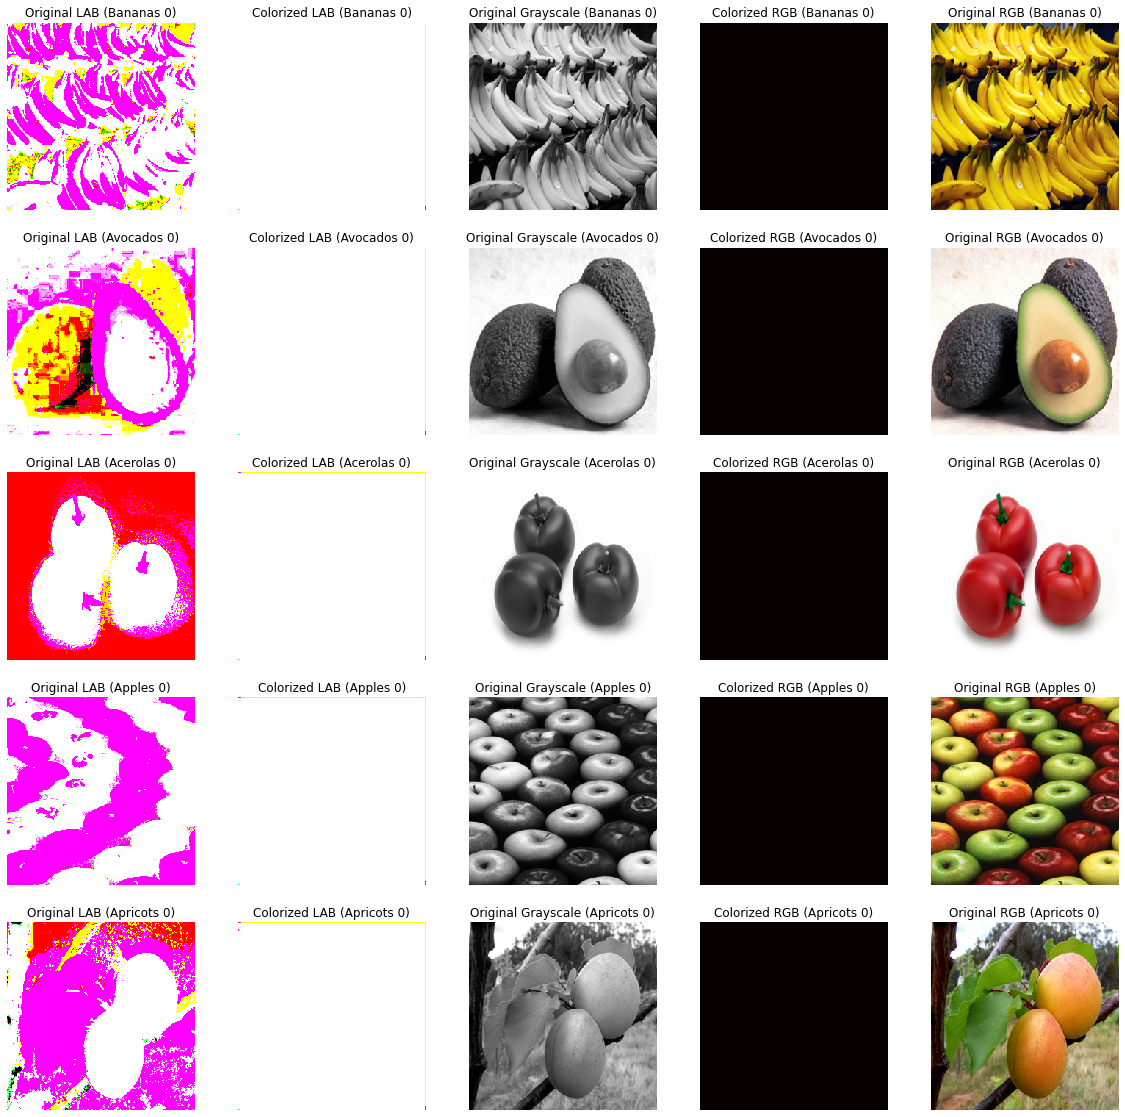

In [ ]:
#Experiment D: change the loss function of model D to 1-ssim
def experimentD():

  colorizationModel = ColorizationModel(modelName, modelChoice=modelChoice, learningRate=learningRate, decay=decay, lossChoice=lossChoice)

  colorizationModel.train(data.x_train, data.lab, 1000)## last parameter should be epoch

  evaluation_three = Evaluation_three()

  dataStart = 0
  numOfData = categoryTestSize
  #evaluation_three.evaluateMetrics(data, colorizationModel.model, dataStart, numOfData)

  #evaluation_three.showAccuracyAndLoss(colorizationModel.history, 'Model Accuracy', 'Model Loss', 'Model Accuracy from Epoch 5', 'Model Loss from Epoch 5', 5)

  evaluation_three.showAllImages(data, colorizationModel.model, dataStart, 1)

  #evaluation_three.showOneImageInfo(2, 'apricots', data, colorizationModel.model)

experimentD()

#Experiment E
Suspended

In [ ]:
#Preparation for ExpE
modelName = 'Model E (5 Fruits) (1000 Epochs) (0.002 lr) (Loss Function = RGBNegSSIM)'
modelChoice = 'modelE'   # Currently have modelA, modelB, and modelC
epochs = 1000
learningRate = 0.002
decay = 0.9
lossChoice = 'RGBNegSSIM'  


In [ ]:
def CustomAccuracy_RGBNegSSIM(y_true, y_pred):
    y_true = y_true[-1,:,:,:]
    y_pred = y_pred[-1,:,:,:]
    y_true = tf.cast(y_true, tf.float32)
    InspectInput(y_true)
    InspectInput(y_pred)
    y_true = tf.expand_dims(y_true, axis = 0)
    y_pred = tf.expand_dims(y_pred, axis = 0)
    loss = tf.image.ssim(y_true, y_pred, 2.0)
    return - loss


In [ ]:
#Experiment E: change the loss function of model D to 1-ssim
def experimentE():

  colorizationModel = ColorizationModel(modelName, modelChoice=modelChoice, learningRate=learningRate, decay=decay, lossChoice=lossChoice)

  colorizationModel.train(data.x_train, data.rgb, 10)## last parameter should be epoch

  evaluation = Evaluation_rgb()

  dataStart = 0
  numOfData = categoryTestSize
  #evaluation.evaluateMetrics(data, colorizationModel.model, dataStart, numOfData)

  #evaluation.showAccuracyAndLoss(colorizationModel.history, 'Model Accuracy', 'Model Loss', 'Model Accuracy from Epoch 5', 'Model Loss from Epoch 5', 5)

  evaluation.showAllImages(data, colorizationModel.model, dataStart, 1)

  #evaluation.showOneImageInfo(2, 'apricots', data, colorizationModel.model)

experimentE()

#ExperimentF

In [ ]:
#Preparation for ExpF
modelName = 'Model D (5 Fruits) (1000 Epochs) (0.002 lr) (Loss Function = NegSSIM)'
modelChoice = 'modelD'   # Currently have modelA, modelB, and modelC
epochs = 1000
learningRate = 0.002
decay = 0.9
lossChoice = 'NegSSIM'  


In [ ]:
def normalizer(x,max,min):
  a = tf.math.divide(tf.math.subtract(x, min), tf.math.subtract(max, min))
  return a

def CustomAccuracy_NegSSIM(y_true, y_pred):
    '''
    range of y_pred = [-1,1]
    shape of y_pred = [None, 256, 256, 2]
    range of y_true = [-1,1]
    shape of y_true = [None, 256, 256, 2]

    Step to calculate SSIM:
    1. remove the batch layer
    2. Cast the data type of y_true from integer to float32
    3. unstack y_true, which is the actual image in L-AB color space to obtain the grayscale for y_pred
    4. Normalize the value of 
    5. expand the dimension to fit the format requirement of the ssim function
    6. return the negative value of ssim function; It is because most similar images have the value of 1. 
       Putting it in the context of loss function, which aim to minimize the parameters, it has to be -1*SSIM
    7. Return it back to the model
    '''
    y_true = y_true[-1,:,:,:]
    y_pred = y_pred[-1,:,:,:]
    y_true = tf.cast(y_true, tf.float32)
    min = tf.math.minimum(tf.reduce_min(y_pred), tf.reduce_min(y_true))
    max = tf.math.maximum(tf.reduce_max(y_pred), tf.reduce_max(y_true))
    y_pred = normalizer(y_pred,max,min)
    y_true = normalizer(y_true,max,min)
    y_true = tf.expand_dims(y_true, axis = 0)
    y_pred = tf.expand_dims(y_pred, axis = 0)
    loss = tf.image.ssim(y_true, y_pred, 2.0, filter_size=3)
    return - loss


In [ ]:
#Experiment F: change the loss function of model B to -1*ssim
def experimentF():

  colorizationModel = ColorizationModel(modelName, modelChoice=modelChoice, learningRate=learningRate, decay=decay, lossChoice=lossChoice)

  colorizationModel.train(data.x_train, data.y_train, 1000)## last parameter should be epoch

  evaluation = Evaluation()

  dataStart = 0
  numOfData = categoryTestSize
  evaluation.evaluateMetrics(data, colorizationModel.model, dataStart, numOfData)

  evaluation.showAccuracyAndLoss(colorizationModel.history, 'Model Accuracy', 'Model Loss', 'Model Accuracy from Epoch 5', 'Model Loss from Epoch 5', 5)

  evaluation.showAllImages(data, colorizationModel.model, dataStart, 1)

  evaluation.showOneImageInfo(2, 'apricots', data, colorizationModel.model)

experimentF()

Output hidden; open in https://colab.research.google.com to view.

#ExperimentF2




In [ ]:
#Preparation for ExpF
modelName = 'Model D (5 Fruits) (1000 Epochs) (0.002 lr) (Loss Function = NegSSIM) Unnormalized data in loss'
modelChoice = 'modelD'   # Currently have modelA, modelB, and modelC
epochs = 1000
learningRate = 0.002
decay = 0.9
lossChoice = 'NegSSIM'  


In [ ]:
def normalizer(x,max,min):
  a = tf.math.divide(tf.math.subtract(x, min), tf.math.subtract(max, min))
  return a

def CustomAccuracy_NegSSIM(y_true, y_pred):
    '''
    range of y_pred = [-1,1]
    shape of y_pred = [None, 256, 256, 2]
    range of y_true = [-1,1]
    shape of y_true = [None, 256, 256, 2]

    Step to calculate SSIM:
    1. remove the batch layer
    2. Cast the data type of y_true from integer to float32
    3. unstack y_true, which is the actual image in L-AB color space to obtain the grayscale for y_pred
    4. Normalize the value of 
    5. expand the dimension to fit the format requirement of the ssim function
    6. return the negative value of ssim function; It is because most similar images have the value of 1. 
       Putting it in the context of loss function, which aim to minimize the parameters, it has to be -1*SSIM
    7. Return it back to the model
    '''
    y_true = y_true[-1,:,:,:]
    y_pred = y_pred[-1,:,:,:]
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.expand_dims(y_true, axis = 0)
    y_pred = tf.expand_dims(y_pred, axis = 0)
    loss = tf.image.ssim(y_true, y_pred, 2.0,filter_size=1)
    return - loss


In [ ]:
#Experiment F: change the loss function of model B to -1*ssim
def experimentF():

  colorizationModel = ColorizationModel(modelName, modelChoice=modelChoice, learningRate=learningRate, decay=decay, lossChoice=lossChoice)

  colorizationModel.train(data.x_train, data.y_train, 1000)## last parameter should be epoch

  evaluation = Evaluation()

  dataStart = 0
  numOfData = categoryTestSize
  evaluation.evaluateMetrics(data, colorizationModel.model, dataStart, numOfData)

  evaluation.showAccuracyAndLoss(colorizationModel.history, 'Model Accuracy', 'Model Loss', 'Model Accuracy from Epoch 5', 'Model Loss from Epoch 5', 5)

  evaluation.showAllImages(data, colorizationModel.model, dataStart, 1)

  evaluation.showOneImageInfo(2, 'apricots', data, colorizationModel.model)

experimentF()

Output hidden; open in https://colab.research.google.com to view.

#ExperimentG

In [ ]:
#Preparation for ExpG
modelName = 'Model D (5 Fruits) (1000 Epochs) (0.002 lr) (Loss Function = NegSSIM) Unnormalized data in loss Small filter'
modelChoice = 'modelD'   # Currently have modelA, modelB, and modelC
epochs = 1000
learningRate = 0.002
decay = 0.9
lossChoice = 'NegSSIM'  


In [ ]:
def normalizer(x,max,min):
  a = tf.math.divide(tf.math.subtract(x, min), tf.math.subtract(max, min))
  return a

def CustomAccuracy_NegSSIM(y_true, y_pred):
    '''
    range of y_pred = [-1,1]
    shape of y_pred = [None, 256, 256, 2]
    range of y_true = [-1,1]
    shape of y_true = [None, 256, 256, 2]

    Step to calculate SSIM:
    1. remove the batch layer
    2. Cast the data type of y_true from integer to float32
    3. unstack y_true, which is the actual image in L-AB color space to obtain the grayscale for y_pred
    4. Normalize the value of 
    5. expand the dimension to fit the format requirement of the ssim function
    6. return the negative value of ssim function; It is because most similar images have the value of 1. 
       Putting it in the context of loss function, which aim to minimize the parameters, it has to be -1*SSIM
    7. Return it back to the model
    '''
    y_true = y_true[-1,:,:,:]/100
    y_pred = y_pred[-1,:,:,:]
    l,a,b = tf.unstack(y_true, axis = 2)
    aa,bb = tf.unstack(y_pred, axis = 2)
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.stack([a,b], axis = 2)
    y_pred = tf.stack([l,aa,bb], axis = 2)
    y_true = tf.stack([l,a,b], axis = 2)
    min = tf.math.minimum(tf.reduce_min(y_pred), tf.reduce_min(y_true))
    max = tf.math.maximum(tf.reduce_max(y_pred), tf.reduce_max(y_true))
    y_pred = normalizer(y_pred,max,min)
    y_true = normalizer(y_true,max,min)
    y_true = tf.expand_dims(y_true, axis = 0)
    y_pred = tf.expand_dims(y_pred, axis = 0)
    loss = tf.image.ssim(y_true, y_pred, 2.0, filter_size=30)
    return - loss


In [ ]:
#Experiment G: change the loss function of model B to -1*ssim
def experimentG():

  colorizationModel = ColorizationModel(modelName, modelChoice=modelChoice, learningRate=learningRate, decay=decay, lossChoice=lossChoice)

  colorizationModel.train(data.x_train, data.lab, 201)## last parameter should be epoch

  evaluation = Evaluation()

  dataStart = 0
  numOfData = categoryTestSize
  evaluation.evaluateMetrics(data, colorizationModel.model, dataStart, numOfData)

  evaluation.showAccuracyAndLoss(colorizationModel.history, 'Model Accuracy', 'Model Loss', 'Model Accuracy from Epoch 5', 'Model Loss from Epoch 5', 5)

  evaluation.showAllImages(data, colorizationModel.model, dataStart, 1)

  evaluation.showOneImageInfo(2, 'apricots', data, colorizationModel.model)

experimentG()

Output hidden; open in https://colab.research.google.com to view.

#Experiment1

In [ ]:
#Preparation for ExpA
modelName = 'Model D (5 Fruits) (1000 Epochs) (0.002 lr) (Loss Function = NegSSIM)'
modelChoice = 'modelD'   # Currently have modelA, modelB, and modelC
epochs = 1000
learningRate = 0.002
decay = 0.9
lossChoice = 'NegSSIM'  


In [ ]:
def test(y_pred, y_true):
    # y_true = y_true[-1,:,:,:] #Remove excessive dimension
    # y_pred = y_pred[-1,:,:,:] #Remove excessive dimension
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = y_pred
    y_true = y_true/100
    InspectInput(y_true)
    InspectInput(y_pred)
    l, _, __ = tf.unstack(y_true, axis = -1)
    a, b = tf.unstack(y_pred, axis = -1)
    y_pred = tf.stack([l,a,b],axis = -1)
    y = tf.stack([y_true, y_pred])
    y = tfio.experimental.color.rgb_to_yuv(tfio.experimental.color.lab_to_rgb(y))
    InspectInput(y_true)
    InspectInput(y_pred)
    loss = tf.image.ssim(y_true,y_pred,2.0)
    tf.print(-1*loss)
    InspectInput(-1*loss)

test(data.y_train[0], data.lab[0])






-0.147827089
1
-0.147827089
0.773509681
-0.147827089
1
-0.147827089
1
-1
-1
-1


In [ ]:
import PIL
def I(x):
  PIL.Image.fromarray(x)
  plt.imshow(x)
  plt.show()
print(I(tfio.experimental.color.lab_to_rgb(data.lab[0])*255))

AttributeError: ignored

In [ ]:
def CustomAccuracy_NegSSIM(y_true, y_pred):
    '''
    range of y_pred = [-1,1]
    shape of y_pred = [None, 256, 256, 2]
    range of y_true = [-1,1]
    shape of y_true = [None, 256, 256, 2]

    Step to calculate SSIM:
    1. remove the batch layer
    2. Cast the data type of y_true from integer to float32
    3. unstack y_true, which is the actual image in L-AB color space to obtain the grayscale for y_pred
    4. Normalize the value of 
    5. expand the dimension to fit the format requirement of the ssim function
    6. return the negative value of ssim function; It is because most similar images have the value of 1. 
       Putting it in the context of loss function, which aim to minimize the parameters, it has to be -1*SSIM
    7. Return it back to the model
    '''
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = y_pred*100
    l, _, __ = tf.unstack(y_true, axis = -1)
    a, b = tf.unstack(y_pred, axis = -1)
    y_pred = tf.stack([l,a,b],axis = -1)
    y_true = tfio.experimental.color.lab_to_rgb(y_true)
    y_pred = tfio.experimental.color.lab_to_rgb(y_pred)
    loss = tf.image.ssim(y_true,y_pred,1.0)
    return 1 - loss


In [ ]:
#Experiment one: change the loss function of model D to -1*ssim
def experimentone():

  colorizationModel = ColorizationModel(modelName, modelChoice=modelChoice, learningRate=learningRate, decay=decay, lossChoice=lossChoice)
  colorizationModel.train(data.x_train, data.lab, epochs)
  model = colorizationModel.model
  history = colorizationModel.history

  ### Evaluation ###
  evaluation = Evaluation()

  dataStart = 0
  numOfData = categoryTestSize
  evaluation.evaluateMetrics(data, model, dataStart, numOfData)
  evaluation.showAccuracyAndLoss(history, 'Model Accuracy', 'Model Loss', 'Model Accuracy from Epoch 5', 'Model Loss from Epoch 5', 5)

  evaluation.showAllImages(data, model, dataStart, 1)

experimentone()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_143 (Conv2D)         (None, 128, 128, 64)      640       
                                                                 
 conv2d_144 (Conv2D)         (None, 128, 128, 128)     73856     
                                                                 
 conv2d_145 (Conv2D)         (None, 64, 64, 128)       147584    
                                                                 
 conv2d_146 (Conv2D)         (None, 64, 64, 256)       295168    
                                                                 
 conv2d_147 (Conv2D)         (None, 32, 32, 256)       590080    
                                                                 
 conv2d_148 (Conv2D)         (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_149 (Conv2D)         (None, 32, 32, 512)     

KeyboardInterrupt: ignored

#Other Functions

In [ ]:
def two(x):
    _, l, a, b = tf.unstack(x, axis=-1)
    return tf.stack([a,b],axis =-1)

def one(y_train):
    y_true = y_train
    l, a, b = tf.unstack( y_true, axis=-1)
    ll, aa, bb = tf.unstack( y_true, axis = -1 )
    y_pred = (tf.stack([aa,bb,l], axis = -1)*100+1)*0.95
    y_true = (tf.stack([a,b,l], axis = -1)*100+1)
    y_true = tf.expand_dims(y_true, axis = 0)
    y_pred = tf.expand_dims(y_pred, axis = 0)
    tf.print(tf.image.ssim(y_true, y_pred, 2.0))
one(data.lab)

[[1.61995316 3.75944877 1.86108875 ... 0.997346401 0.997380257 0.997374535]]


In [ ]:
evaluation = Evaluation()

dataStart = 0
numOfData = categoryTestSize
evaluation.evaluateMetrics(data, model.model, dataStart, numOfData)

evaluation.showAccuracyAndLoss(model.history, 'Model Accuracy', 'Model Loss', 'Model Accuracy from Epoch 5', 'Model Loss from Epoch 5', 5)

evaluation.showAllImages(data, model.model, dataStart, 1)

evaluation.showOneImageInfo(2, 'apricots', data, model.model)

In [ ]:
def InspectInput(x):
  tf.print(tf.math.reduce_min(x))
  tf.print(tf.math.reduce_max(x))

In [ ]:
# If from loaded model
modelToLoad = pwd + 'TrainedModel (Kyle)/' + 'name of the model'
model = tf.keras.models.load_model(modelToLoad)